In [279]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.special import jv
from scipy.interpolate import interp1d

In [191]:
'''
NON - Geometrized constants
'''

c = 299792458                 # Speed of light: m/s
G = 6.6743e-11                # Gravitational Constant: m^3 / (kg s^2)
Msun = 2e30                   # Solar Masses: kg
M = 4e6 * Msun                # SMBH Mass: kg
parsec_to_m = 3e16            # meters per parsec
mstar = 0.05 * Msun           # CO Mass: kg
mu = (M * mstar) / (M + mstar)# reduced mass
D = 1e3*parsec_to_m*8         # Distance to galactic center: meters
yr = 3600.0*24.0*365.0        # One year in seconds


In [193]:
# Peters' equations (da/dt, de/dt)
def dadt(a, e):
    """
    Rate of change of semi-major axis
    (Peters 1964)
    """
    return -(64/5) * (G**3 * M* mstar * (M + mstar)) / (c**5 * a**3 * (1 - e**2)**(3.5)) * (1 + (73/24)*e**2 + (37/96)*e**4)

def dedt(a, e):
    """
    Rate of change of eccentricity 
    (Peters 1964)
    """
    return -(304/15) * (e * G**3 * M * mstar * (M+mstar)) / (c**5 * a**4 *(1-e**2)**(2.5)) * (1 + (121/304)*e**2)

def deriv(t,y):
    a, e = y
    da = dadt(a, e)
    de = dedt(a, e)
    return [da, de]

# Initial conditions
a0 = 2/1000 * parsec_to_m  # initial semi-major axis
e0 = 0.999                # initial eccentricity
y0 = [a0, e0]

In [201]:
tfinal = (10**9 * 365 * 24 * 3600)  # Total time seconds

sol = solve_ivp(
    deriv, 
    t_span=(0, tfinal), 
    y0=y0, 
    rtol=1e-10, 
    atol=1e-12
)

t_arr = sol.t                              # Time array (seconds)
a_arr, e_arr = sol.y                       # a_arr: semi-major axis (meters), e_arr: eccentricity (unitless)

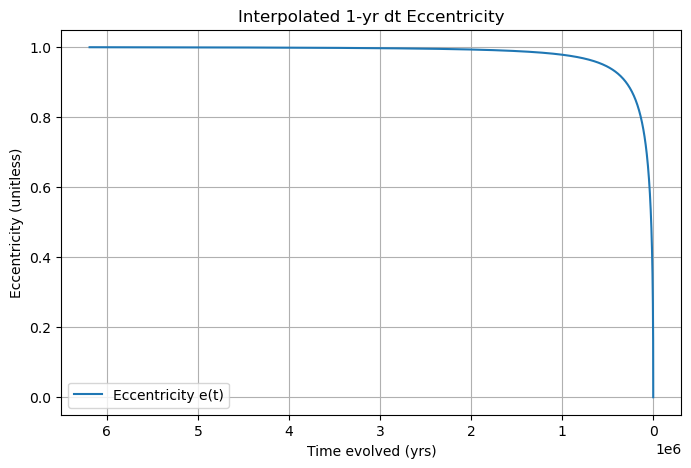

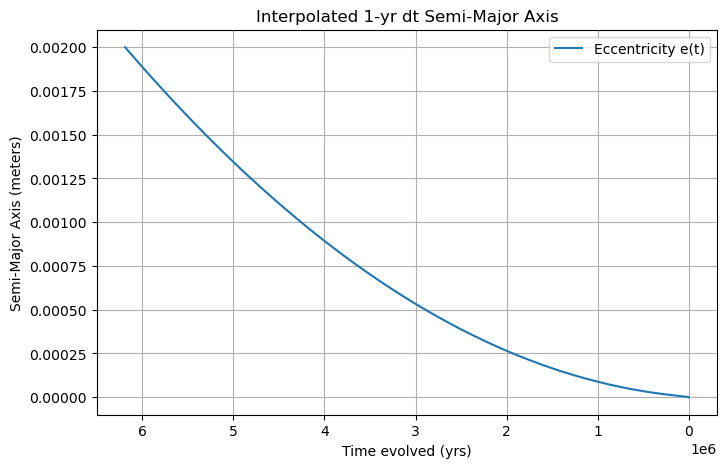

In [283]:
'''
Create interpolation plots for t, a, e
'''

f1 = interp1d(t_arr, e_arr)
f2 = interp1d(t_arr, a_arr)

t_new = np.linspace(min(t_arr), max(t_arr), num=round(np.max(t_arr/yr)))
e_arr_new = f1(t_new)
a_arr_new = f2(t_new)

t_to_plunge_yr_new = (t_new[-1] - t_new) / yr

# Plot results
plt.figure(figsize=(8,5))
plt.plot(t_to_plunge_yr_new, e_arr_new, label='Eccentricity e(t)')
plt.xlabel('Time evolved (yrs)')
plt.ylabel('Eccentricity (unitless)')
plt.title("Interpolated 1-yr dt Eccentricity")
plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()
plt.show()

# Plot results
plt.figure(figsize=(8,5))
plt.plot(t_to_plunge_yr_new, a_arr_new/parsec_to_m, label='Eccentricity e(t)')
plt.xlabel('Time evolved (yrs)')
plt.ylabel('Semi-Major Axis (meters)')
plt.title("Interpolated 1-yr dt Semi-Major Axis")
plt.grid(True)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

In [211]:
from few.waveform import GenerateEMRIWaveform
from few.utils.constants import MTSUN_SI
from few.utils.utility import get_p_at_t
from few.utils.geodesic import get_fundamental_frequencies
from few.utils.fdutils import GetFDWaveformFromFD, GetFDWaveformFromTD
from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode.flux import KerrEccEqFlux
from scipy.interpolate import CubicSpline
from few import get_file_manager
from scipy.integrate import cumulative_trapezoid

'''
Calculating FEW waveform to develop the sensitivity of LISA instrument
'''

In [213]:
# produce sensitivity function
traj_module = EMRIInspiral(func=KerrEccEqFlux)

# import ASD
data = np.loadtxt(get_file_manager().get_file("LPA.txt"), skiprows=1)
frequencies = data[:,0]
psd_values  = data[:, 1] ** 2
# define PSD function
get_sensitivity = CubicSpline(frequencies, psd_values)

In [214]:
def h_det(f):
    '''
    Return FEW Waveform sensitivity

    To use in SNR, must take the square root
    '''
    return (get_sensitivity(f))

In [30]:
def g_n_e(n, e):
    '''
    Bessel function of the first kind, unitless

    Equation 59 of Barack and Cutler (2003)
    '''
    ne = n*e
    Jn_2 = jv(n-2, ne)
    Jn_1 = jv(n-1, ne)
    Jn   = jv(n,   ne)
    Jn1  = jv(n+1, ne)
    Jn2  = jv(n+2, ne)
    term1 = Jn_2 - 2*e*Jn_1 + (2.0/n)*Jn + 2*e*Jn1 - Jn2
    term2 = Jn_2 - 2*Jn + Jn2
    return (n**4/32.0) * (term1**2 + (1 - e**2)*term2**2 + (4.0/(3*n**2))*(Jn**2))


In [32]:
def h_n(n,e,a):
    '''
    Returns unitless strain value

    Equation above 11 Pau (2019)
    '''
    return g_n_e(n, e)*G**2 *M*mstar/(D*(c**4)*a)

In [34]:
def f_orb(a):
    '''
    Keplerian orbital frequency
    Returns in seconds^-1
    '''
    return (1/(2*np.pi))*np.sqrt(G*(M+mstar)/a**3)

In [ ]:
'''
The following plot attempts to replicate Fig 3 in Pau's Paper (2019)
'''

In [301]:
time_arrays = np.array([1e6, 1e5, 1e4, 1000, 1]) # Values to plot the characteristic strain at (years)
idxs = [np.argmin(np.abs(t_to_plunge_yr_new - T)) for T in time_arrays] # Grab the closest point at that time
print(time_to_plunge_yr[idxs]) # Approximately the right times in time_array -> Much closer with interpolated values

[1.00000019e+06 1.00000019e+05 1.00000019e+04 1.00000019e+03
 1.00000019e+00]


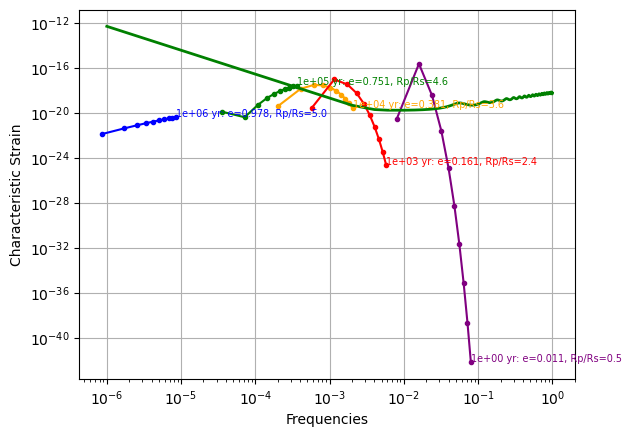

'\nThis plot shows that there is still some inaccuracies in the overall strain calculation, but the time vs eccentricities are very close to the\noriginals in the paper. I would take this to show that the difference due to the PN evolved equations is not as large as what would cause these\ndifferences. \n\n'

In [303]:
colors = ['blue', 'green', 'orange', 'red', 'purple']

for j, (T, idx, color) in enumerate(zip(time_arrays, idxs, colors)):
    e = e_arr_new[idx]
    a = a_arr_new[idx]
    f_orbital = f_orb(a)  # Hz
    n_vals = np.arange(1, 11) # Array of integers 1 to 10
    f_n = n_vals * f_orbital
    h_n_vals = np.array([h_n(n, e, a) for n in range(1, 11)])
    h_c_vals = h_n_vals * np.sqrt(f_n*yr)
    
    plt.loglog(f_n, h_c_vals, color=color)
    plt.plot(f_n[:10], h_c_vals[:10], 'o', color=color, markersize=3)
    
    # Annotate with Rp/Rs and e
    R_s = 2 * G * M / c**2
    Rp_Rs = a * (1 - e) / R_s
    plt.text(f_n[9], h_c_vals[9]*1.2, f"{int(T):.0e} yr: e={e:.3f}, Rp/Rs={Rp_Rs:.1f}", color=color, fontsize=7)

plt.loglog(np.linspace(10**(-6),1, 500), np.sqrt(h_det(np.linspace(10**(-6),1, 500))), lw=2, color = 'green')
plt.xlabel('Frequencies')
plt.ylabel('Characteristic Strain')
plt.grid(True)
plt.show()

'''
This plot shows that there is still some inaccuracies in the overall strain calculation, but the time vs eccentricities are very close to the
originals in the paper. I would take this to show that the difference due to the PN evolved equations is not as large as what would cause these
differences. 

'''

In [151]:
def integral(a, e, n,dt_i):
    #for n in range(1, n+1):
    f_Hz = n * f_orb(a)
    hn   = h_n(n, e, a)
    hdet = np.sqrt(h_det(f_Hz))  # ASD

    return (hn/hdet)**2 * (dt_i)

In [169]:
def integrate_function(P, t_s):
        S = np.concatenate([[0.0], np.cumsum(P)])         # simple sum (since P already includes dt)
        # find index j such that t_s[j] - t_s[i] ~ 1 yr
        idx_end = np.searchsorted(t_s, t_s + yr, side='right') - 1
        idx_end = np.clip(idx_end, 0, len(P)-1)
        # integral from i to j is sum P[k] for k in [i, j]
        return S[idx_end+1] - S[:-1]

In [305]:
def snr_1yr_vs_time(a_arr, e_arr, t_arr, N_harm_show=10, N_harm_sum=1000):
    dt_arr = np.diff(t_arr, prepend=t_arr[0])
    T = len(t_arr)
    integral_value_show = np.zeros((N_harm_show, T))
    integral_value_total = np.zeros(T)

    # Calculating the integral at each time
    for i in range(T):
        a, e, dt_meters = a_arr[i], e_arr[i], dt_arr[i]
        
        for n in range(1, N_harm_show+1):
            integral_value_show[n-1, i] =  integral(a, e, n,dt_meters)
        s = 0.0
        for n in range(1, N_harm_sum+1):
            s += integral(a, e, n,dt_meters)
        integral_value_total[i] = s

    # Converting back to seconds
    #dt_s = dt_arr / c                           # seconds
    t_s  = np.cumsum(dt_arr)                       # seconds from start
    
    SNR2_total_1yr = integral_value_total#integrate_function(integral_value_total, t_s)
    SNR2_total_1yr_integrated = integrate_function(integral_value_total, t_s)
    SNR2_show_1yr_integrated  = np.vstack([integrate_function(integral_value_show[k], t_s) for k in range(N_harm_show)])
    SNR2_show_1yr  = np.vstack([integral_value_show[k] for k in range(N_harm_show)])

    # x-axis: time to plunge (years), reverse so it decreases to the right
    t_to_plunge_yr = (t_arr[-1] - t_arr) / yr

    return t_to_plunge_yr, np.sqrt(SNR2_total_1yr), np.sqrt(SNR2_show_1yr), np.sqrt(SNR2_total_1yr_integrated)

In [307]:
def plot_SNR(a_arr, e_arr, t_arr, N_harm_show=10, N_harm_sum=1000):
    time_to_plunge, SNR_tot, SNR_h, SNR_integrated = snr_1yr_vs_time(a_arr, e_arr, t_arr)

    plt.figure(figsize=(8,6))
    for i in range(SNR_h.shape[0]):
        plt.loglog(time_to_plunge, SNR_h[i], '--', lw=1)
    plt.loglog(time_to_plunge, SNR_tot, 'k', lw=2, label='Total SNR (sum up to n={1000})')
    #plt.loglog(time_to_plunge, SNR_integrated, lw=2, color = 'green')
    plt.xlim(1e7, 1) 
    plt.xlabel('Time to plunge (yr)')
    plt.ylabel('SNR for 1-yr observation')
    plt.title('SNR for 1-yr observation vs Time to Plunge')
    plt.grid(True, which='both', ls=':')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [ ]:
plot_SNR(a_arr_new, e_arr_new, t_new)#, N_harm_show=10, N_harm_sum=1000)

In [267]:
spacings = np.diff(t_new)      # Calculate differences between adjacent elements
average_spacing = np.min(np.abs(spacings))
print(average_spacing/yr)

1.000000189267821
